## HW1-DL

> 姓名：王子轩
>
> 学号：2023011307
>
> 邮箱：`wang-zx23@mails.tsinghua.edu.cn`

[TOC]

### **1**

> Code analysis

#### 1.1 Error analysis

关键在于正确分析`d2l`中默认的`trainer`函数的方法：在`L4_wrong.ipynb`给出的代码实现中`SoftmaxRegressionScratch` 类继承自 `Classifier` ，且没有显式定义 loss 方法，模型会使用父类的默认损失函数实现，可以通过如下代码运行得到:

```python
import inspect
print(inspect.getsource(d2l.Classifier.loss))
# output:
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = d2l.reshape(Y, (-1,))
    return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')
```

可以看到父类的损失函数期望的是原始的 logits（即未经过 softmax 处理的值）, 因为 F.cross_entropy 内部会自动应用softmax.而由于我们 forward 方法输出的是经过自定义 softmax 函数处理的概率值

```python
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return self.softmax(torch.matmul(X, self.W) + self.b)
```

这会导致对已经通过 softmax 转为参数化概率的值再次应用 softmax ，softmax 函数是有饱和区的，双重 softmax 会影响梯度传播，因此训练效果不佳，我们发现训练损失曲线很快无法下降. 正常的softmax回归过程是依次进行：线性变换：$o = Wx + b$ (logits)，softmax 函数：$p_i = \frac{e^{o_i}}{\sum_j e^{o_j}}$， 交叉熵损失：$L = -\sum_i y_i \log(p_i)$. 按照源代码就变成$q_i = \frac{e^{p_i}}{\sum_j e^{p_j}}$, 最终损失：$L = -\sum_i y_i \log(q_i)$. 

#### 1.2 Experiments and results

我们做实验来证明我们的说法：在如下的代码中，我们先使用正确的交叉熵损失函数，可以得到合理的训练结果；再将正确的实现注释掉，手动实现双重 softmax 层，得到训练结果如图所示

```python
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l
class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)
    def text_labels(self, indices):
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
class Classifier(d2l.Module):  #@save
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
    
    def accuracy(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare


class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
    # 正确实现方式
    # def loss(self, Y_hat, Y):  
    #     return cross_entropy(Y_hat, Y)
    # 模拟错误情形
    def loss(self, Y_hat, Y):
        second_softmax = self.softmax(Y_hat)
        return -torch.log(second_softmax[range(len(Y_hat)), Y]).mean()
    def training_step(self, batch): 
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        self.plot('acc', self.accuracy(self(*batch[:-1]), batch[-1]), train=True)
        return l
    def parameters(self):
        return [self.W, self.b]    
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return self.softmax(torch.matmul(X, self.W) + self.b)   
    def softmax(self, X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(1, keepdims=True)
        return X_exp / partition
```

Results

| 正确实现训练                                                 | 模拟错误情形                                                 | 改正源码后                                                   |
| ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------ |
| ![image-20250402193341404](assets/image-20250402193341404.png) | ![image-20250402193413237](assets/image-20250402193413237.png) | ![image-20250408203352839](assets/image-20250408203352839.png) |

#### 1.3 Source code corrections

在源代码训练前，在 model 中加入如下自定义 loss 损失函数，得到结果如上图第三张结果所示，详细代码可见文件夹中的`L4_contrary.ipynb`

```python
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')
```

### **2**

> Image Classification: Data of 10 categories of image classification from the ImageNet dataset and load 10 categories used for this assignments. 分别使用如下三种模型进行pre-train
- Simple 2-layer NN
- MLP
- CNN

#### 2.1 Dataset visualization 
```txt
.
├── data/
│   ├── CIFAR-10/
│   │   ├── cifar-10-batches-py/
│   │   │   ├── batches.meta
│   │   │   ├── data_batch_1
│   │   │   ├── data_batch_2
│   │   │   ├── data_batch_3
│   │   │   ├── data_batch_4
│   │   │   ├── data_batch_5
│   │   │   └── test_batch
│   │   └── readme.html
│   │
│   └── mini-imagenet/
│       ├── n01532829/  
│       │   ├── n0153282900000005.jpg
│       │   ├── n0153282900000006.jpg
│       │   └── ...
│       ├── n02074367/  
│       │   ├── n0207436700000023.jpg
│       │   └── ...
│       ├── n02087394/  
│       │   └── ...
│       ├── n02120079/ 
│       │   └── ...
│       ├── n02747177/  
│       │   └── ...
│       ├── n03775546/  
│       │   └── ...
│       ├── n03854065/  
```
##### mini-imagenet 


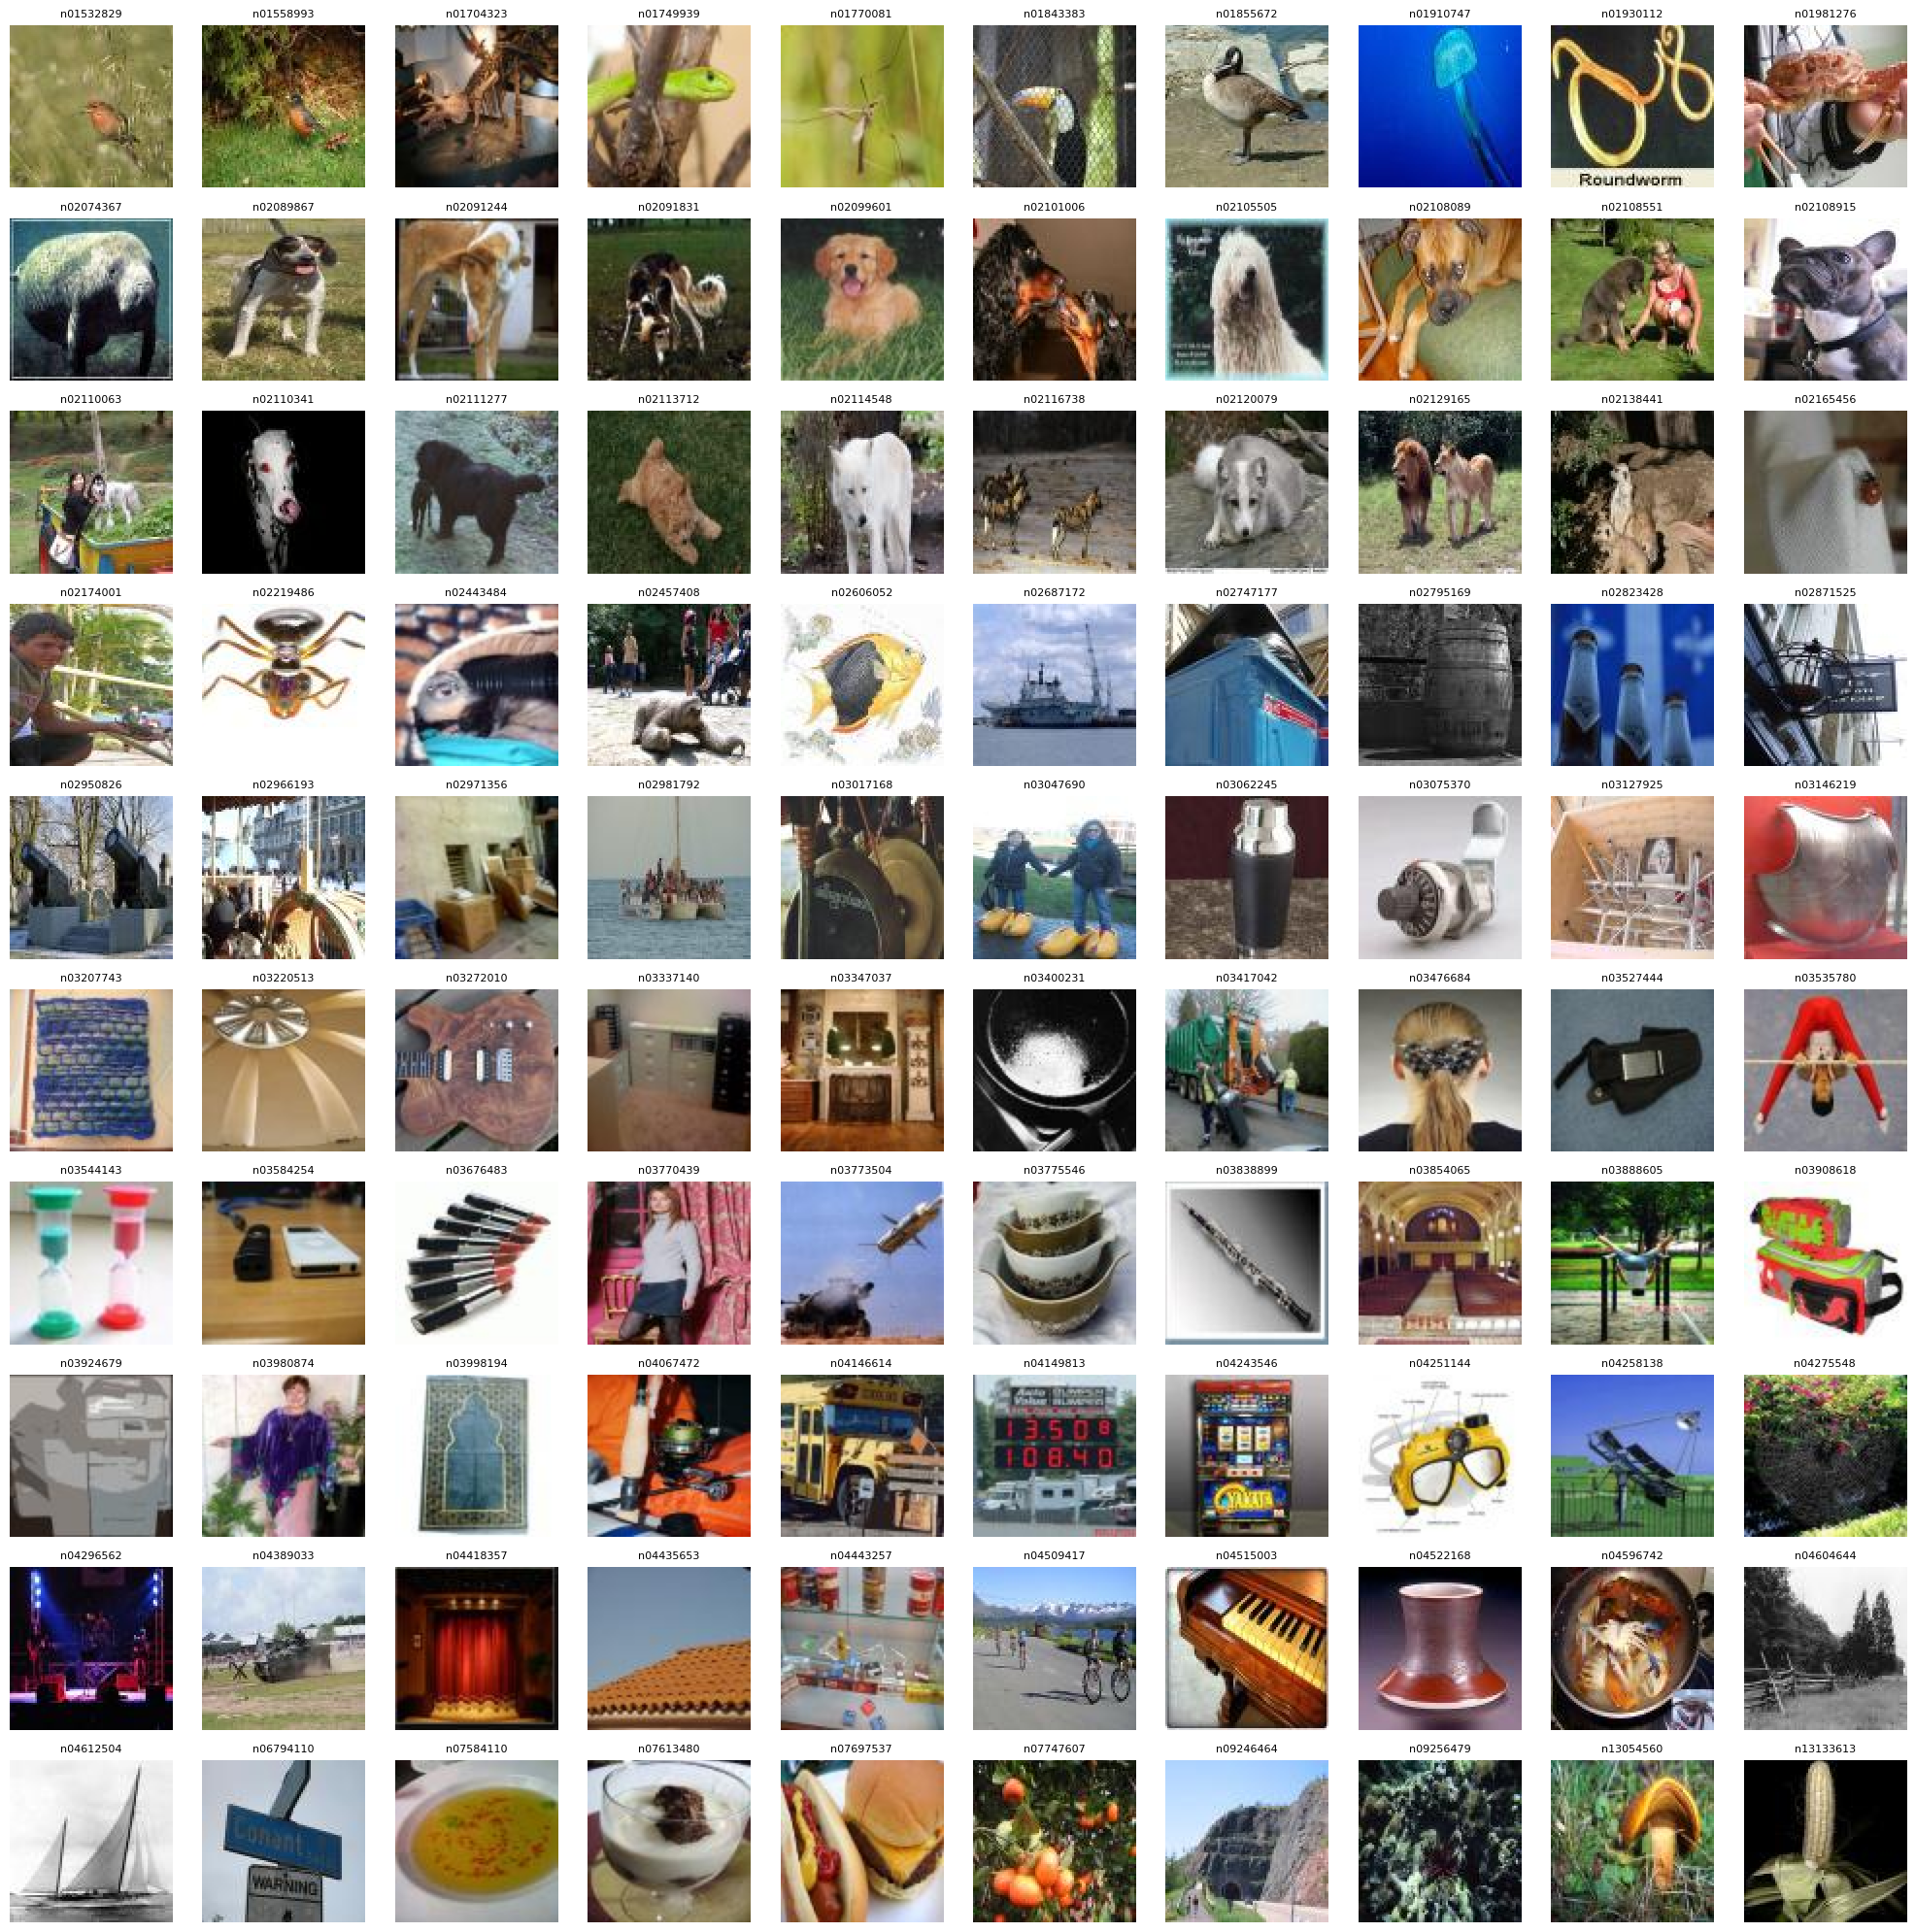

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
dataset_path = 'data/mini-imagenet'
class_folders = sorted(os.listdir(dataset_path))
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for idx, class_folder in enumerate(class_folders):
    folder_path = os.path.join(dataset_path, class_folder)
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    if image_files:
        image_path = os.path.join(folder_path, image_files[0])
        img = Image.open(image_path)
        row = idx // 10
        col = idx % 10
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(class_folder, fontsize=8)
plt.tight_layout()
plt.show()


首先使用从`nltk`库导出每个图片的文本标签和文本描述(运行`utils.py`)，并使用 t-SNE 方法从这100类图片中，我们按照语义相似性原则选择出具有代表性的10类图片，构建细粒度-粗粒度(5-5)难度梯度数据集. (运行`category_analysis.py`)
```txt
细粒度分类类别(相似度高):
n02110341: dalmatian
n02971356: carton
n03127925: crate
n03908618: pencil_box
n04509417: unicycle
粗粒度分类类别(相似度低):
n02606052: rock_beauty
n07613480: trifle
n07697537: hotdog
n01704323: triceratops
n01749939: green_mamba
```



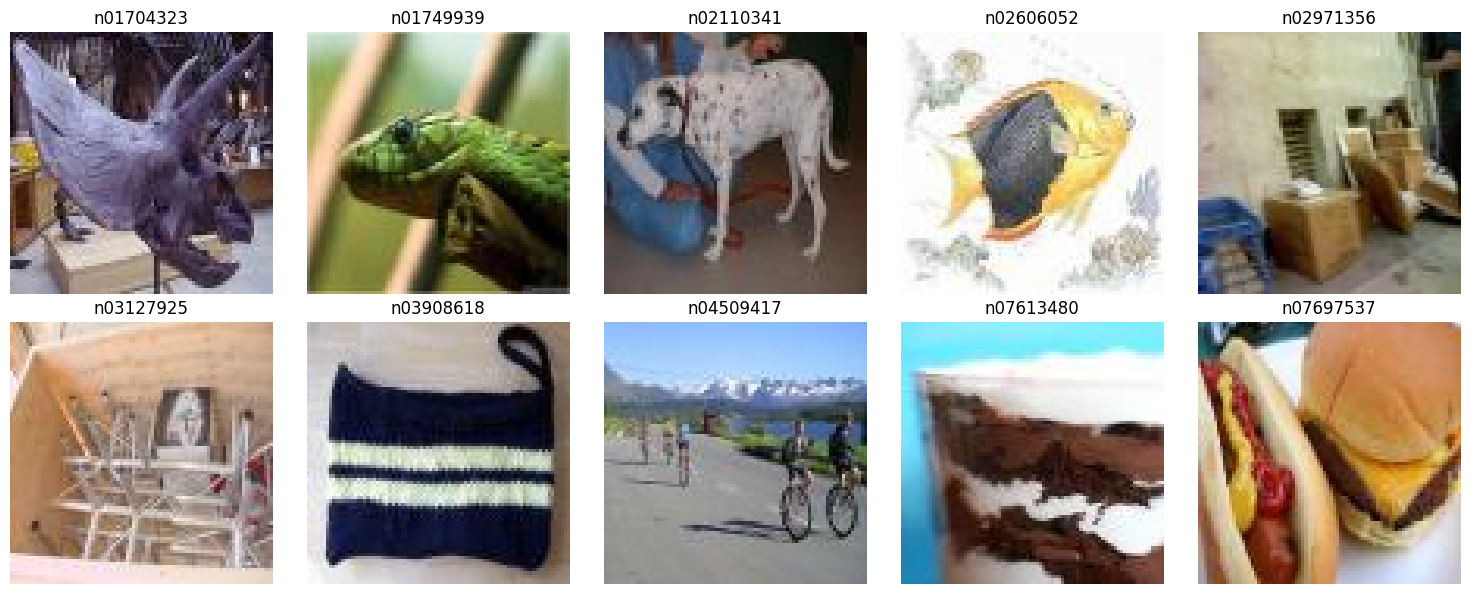

In [ ]:
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from PIL import Image

data_dir = 'data/custom-dataset/train'

classes = os.listdir(data_dir)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'{class_name}')

plt.tight_layout()
plt.show()


接下来，我们使用这些图像类别来构建`train`、`val`和`test dataset`. (运行`build_dataset.py`),比例设置为3:1:1，也就是说每一类的图片，我们将其中360张作为`train`，120张作为`val`，120张作为`test`. 下面先进行预实验，保证baseline可以跑通

使用设备: cuda
类别: ['n01704323', 'n01749939', 'n02110341', 'n02606052', 'n02971356', 'n03127925', 'n03908618', 'n04509417', 'n07613480', 'n07697537']

开始 2LayerNN 预实验


Epoch 1/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 58.68it/s]


Epoch 1/3: Train Loss: 2.4077, Train Acc: 18.50%, Val Loss: 2.3446, Val Acc: 23.00%


Epoch 2/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 66.77it/s]


Epoch 2/3: Train Loss: 1.9815, Train Acc: 32.50%, Val Loss: 2.2697, Val Acc: 27.00%


Epoch 3/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 64.94it/s]


Epoch 3/3: Train Loss: 1.9191, Train Acc: 31.50%, Val Loss: 2.1935, Val Acc: 23.00%

开始 MLP 预实验


Epoch 1/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 64.23it/s]


Epoch 1/3: Train Loss: 2.3471, Train Acc: 12.00%, Val Loss: 2.2735, Val Acc: 16.00%


Epoch 2/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 60.40it/s]


Epoch 2/3: Train Loss: 2.1045, Train Acc: 25.00%, Val Loss: 2.1956, Val Acc: 26.00%


Epoch 3/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 64.67it/s]


Epoch 3/3: Train Loss: 1.9965, Train Acc: 34.00%, Val Loss: 2.1431, Val Acc: 25.00%

开始 CNN 预实验


Epoch 1/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 36.44it/s]


Epoch 1/3: Train Loss: 2.3952, Train Acc: 16.50%, Val Loss: 2.1892, Val Acc: 24.00%


Epoch 2/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 41.70it/s]


Epoch 2/3: Train Loss: 1.8099, Train Acc: 40.00%, Val Loss: 2.0247, Val Acc: 32.00%


Epoch 3/3 [Val]: 100%|██████████| 7/7 [00:00<00:00, 40.86it/s]


Epoch 3/3: Train Loss: 1.5207, Train Acc: 52.50%, Val Loss: 1.9262, Val Acc: 36.00%


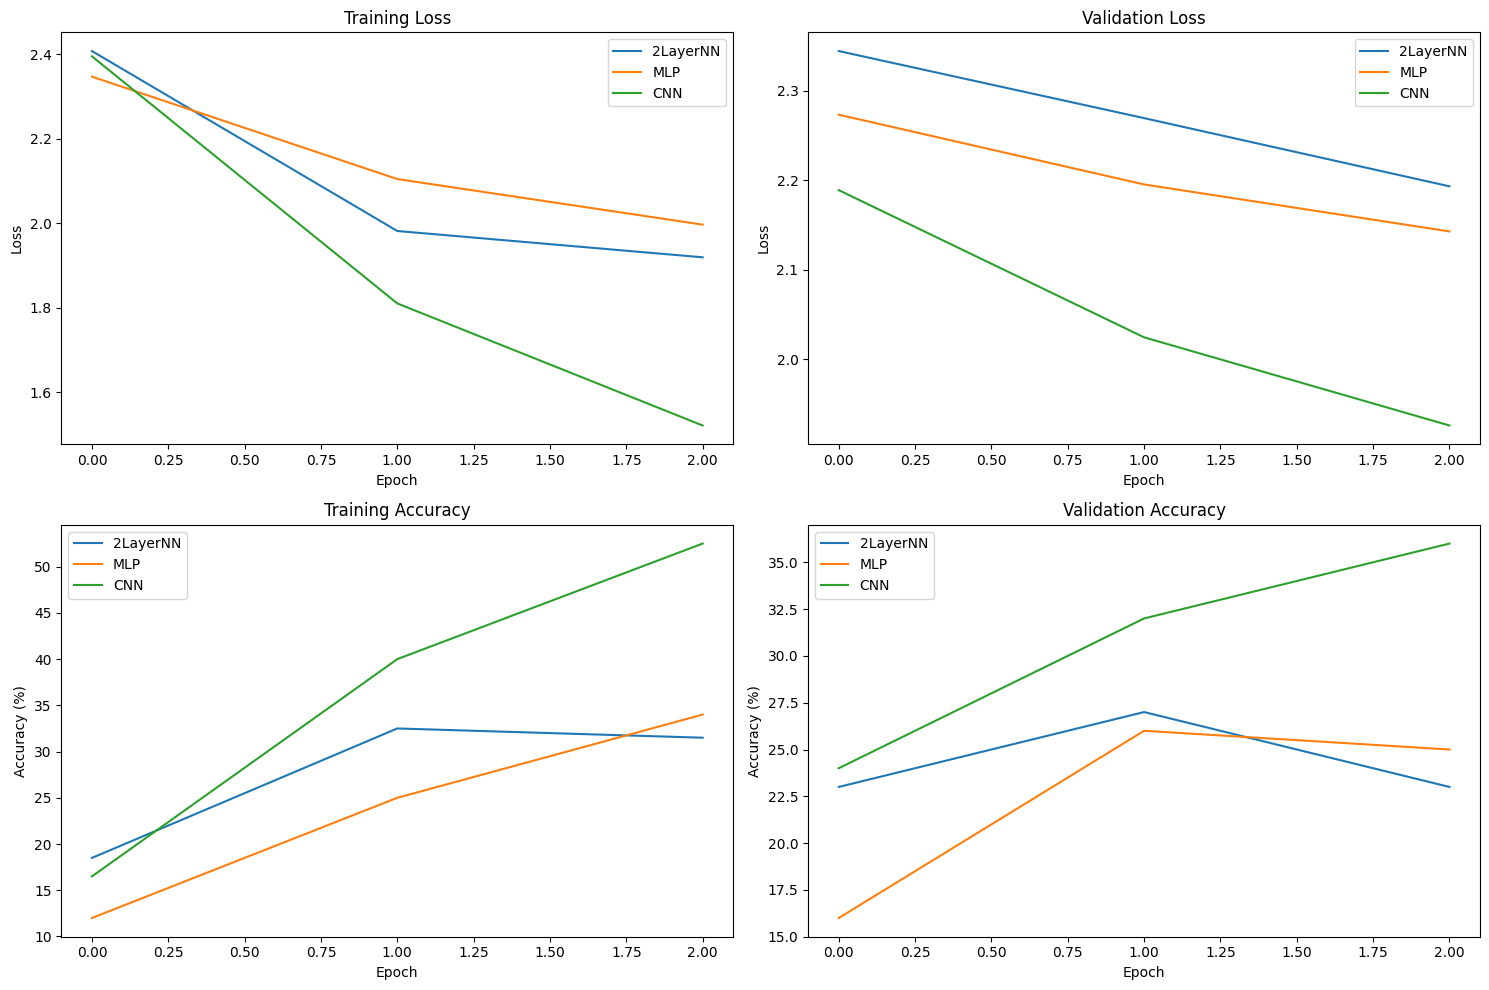

预实验完成!


In [ ]:
# 小批量预实验, 证明代码可以跑通
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import sys
from mlp import MLP
from cnn import CNN
from layer2NN import TwoLayerNN
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')
def get_small_data_loaders(data_dir='data/custom-dataset', batch_size=16, img_size=224, num_samples=50):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
    val_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform)
    train_indices = []
    for class_idx in range(10):
        class_indices = [i for i, (_, label) in enumerate(train_dataset) if label == class_idx]
        train_indices.extend(class_indices[:num_samples])
    
    val_indices = []
    for class_idx in range(10):
        class_indices = [i for i, (_, label) in enumerate(val_dataset) if label == class_idx]
        val_indices.extend(class_indices[:num_samples//2])
    
    small_train_dataset = Subset(train_dataset, train_indices)
    small_val_dataset = Subset(val_dataset, val_indices)
    
    train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, train_dataset.classes

def quick_train(model, train_loader, val_loader, criterion, optimizer, device, epochs=3):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
        
        train_loss = train_loss / train_total
        train_acc = 100. * train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        val_loss = val_loss / val_total
        val_acc = 100. * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return history

def run_preexperiment():
    train_loader, val_loader, class_names = get_small_data_loaders(num_samples=20)
    print(f'类别: {class_names}')
    
    input_size = 3 * 224 * 224
    models = {
        '2LayerNN': TwoLayerNN(input_size=input_size, hidden_size=512, num_classes=10),
        'MLP': MLP(input_size=input_size, hidden_sizes=[512, 256], num_classes=10),
        'CNN': CNN(num_classes=10)
    }
    
    criterion = nn.CrossEntropyLoss()
    
    results = {}
    
    for model_name, model in models.items():
        print(f'\n开始 {model_name} 预实验')
        
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        history = quick_train(model, train_loader, val_loader, criterion, optimizer, device)
        
        results[model_name] = history
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    return results

def plot_preexperiment_results(results):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for model_name, history in results.items():
        plt.plot(history['train_loss'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    for model_name, history in results.items():
        plt.plot(history['val_loss'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    for model_name, history in results.items():
        plt.plot(history['train_acc'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    for model_name, history in results.items():
        plt.plot(history['val_acc'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('preexperiment_results.png')
    plt.show()

if __name__ == '__main__':
    data_dir = 'data/custom-dataset'
    if not os.path.exists(data_dir):
        print(f'错误: 数据集路径 {data_dir} 不存在!')
    else:
        results = run_preexperiment()
        plot_preexperiment_results(results)
        
        print('预实验完成!')

使用设备: cuda
两层神经网络模型结构: 输入维度=21168, 隐藏层大小=2048, 输出类别=10
开始训练两层神经网络模型...


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.43it/s, loss=1.82, acc=35.2]


Epoch 1/30: Train Loss: 2.0231, Train Acc: 28.50%, Val Loss: 1.8218, Val Acc: 35.17%
Model saved with Val Acc: 35.17%


Epoch 2/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.96it/s, loss=1.77, acc=39.2]


Epoch 2/30: Train Loss: 1.8042, Train Acc: 37.39%, Val Loss: 1.7662, Val Acc: 39.17%
Model saved with Val Acc: 39.17%


Epoch 3/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.80it/s, loss=1.83, acc=35.9]


Epoch 3/30: Train Loss: 1.7384, Train Acc: 40.00%, Val Loss: 1.8260, Val Acc: 35.92%


Epoch 4/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.12it/s, loss=1.73, acc=40.2]


Epoch 4/30: Train Loss: 1.6758, Train Acc: 41.53%, Val Loss: 1.7320, Val Acc: 40.17%
Model saved with Val Acc: 40.17%


Epoch 5/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 78.66it/s, loss=1.72, acc=42.2]


Epoch 5/30: Train Loss: 1.6405, Train Acc: 43.14%, Val Loss: 1.7223, Val Acc: 42.25%
Model saved with Val Acc: 42.25%


Epoch 6/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 78.05it/s, loss=1.74, acc=39.2]


Epoch 6/30: Train Loss: 1.5979, Train Acc: 44.83%, Val Loss: 1.7368, Val Acc: 39.17%


Epoch 7/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.25it/s, loss=1.71, acc=40.4]


Epoch 7/30: Train Loss: 1.5574, Train Acc: 45.72%, Val Loss: 1.7054, Val Acc: 40.42%


Epoch 8/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.00it/s, loss=1.7, acc=41.8] 


Epoch 8/30: Train Loss: 1.5328, Train Acc: 47.47%, Val Loss: 1.6985, Val Acc: 41.75%


Epoch 9/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.91it/s, loss=1.67, acc=41.8]


Epoch 9/30: Train Loss: 1.4933, Train Acc: 48.89%, Val Loss: 1.6689, Val Acc: 41.83%


Epoch 10/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.46it/s, loss=1.66, acc=43.6]


Epoch 10/30: Train Loss: 1.4597, Train Acc: 50.61%, Val Loss: 1.6596, Val Acc: 43.58%
Model saved with Val Acc: 43.58%


Epoch 11/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.58it/s, loss=1.66, acc=42.9]


Epoch 11/30: Train Loss: 1.4270, Train Acc: 50.92%, Val Loss: 1.6608, Val Acc: 42.92%


Epoch 12/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.28it/s, loss=1.68, acc=42.8]


Epoch 12/30: Train Loss: 1.4037, Train Acc: 51.39%, Val Loss: 1.6785, Val Acc: 42.83%


Epoch 13/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 66.62it/s, loss=1.7, acc=43.1] 


Epoch 13/30: Train Loss: 1.3939, Train Acc: 52.53%, Val Loss: 1.6975, Val Acc: 43.08%


Epoch 14/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.37it/s, loss=1.68, acc=42.8]


Epoch 14/30: Train Loss: 1.3735, Train Acc: 53.25%, Val Loss: 1.6822, Val Acc: 42.75%


Epoch 15/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.10it/s, loss=1.63, acc=44]  


Epoch 15/30: Train Loss: 1.2415, Train Acc: 58.81%, Val Loss: 1.6332, Val Acc: 44.00%
Model saved with Val Acc: 44.00%


Epoch 16/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.66it/s, loss=1.63, acc=45.2]


Epoch 16/30: Train Loss: 1.2226, Train Acc: 59.11%, Val Loss: 1.6326, Val Acc: 45.25%
Model saved with Val Acc: 45.25%


Epoch 17/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 66.77it/s, loss=1.62, acc=45]  


Epoch 17/30: Train Loss: 1.2067, Train Acc: 59.19%, Val Loss: 1.6189, Val Acc: 45.00%


Epoch 18/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.87it/s, loss=1.62, acc=45.2]


Epoch 18/30: Train Loss: 1.1792, Train Acc: 61.08%, Val Loss: 1.6250, Val Acc: 45.17%


Epoch 19/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 59.00it/s, loss=1.62, acc=45.8]


Epoch 19/30: Train Loss: 1.1587, Train Acc: 61.69%, Val Loss: 1.6155, Val Acc: 45.75%
Model saved with Val Acc: 45.75%


Epoch 20/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.23it/s, loss=1.61, acc=44.6]


Epoch 20/30: Train Loss: 1.1637, Train Acc: 61.31%, Val Loss: 1.6143, Val Acc: 44.58%


Epoch 21/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.64it/s, loss=1.63, acc=44.7]


Epoch 21/30: Train Loss: 1.1545, Train Acc: 62.25%, Val Loss: 1.6259, Val Acc: 44.67%


Epoch 22/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.96it/s, loss=1.63, acc=45]  


Epoch 22/30: Train Loss: 1.1464, Train Acc: 62.08%, Val Loss: 1.6273, Val Acc: 45.00%


Epoch 23/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.11it/s, loss=1.62, acc=45.8]


Epoch 23/30: Train Loss: 1.1477, Train Acc: 62.67%, Val Loss: 1.6184, Val Acc: 45.83%
Model saved with Val Acc: 45.83%


Epoch 24/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 77.01it/s, loss=1.62, acc=45.1]


Epoch 24/30: Train Loss: 1.1408, Train Acc: 62.89%, Val Loss: 1.6155, Val Acc: 45.08%


Epoch 25/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 62.59it/s, loss=1.62, acc=45.1]


Epoch 25/30: Train Loss: 1.1293, Train Acc: 63.58%, Val Loss: 1.6177, Val Acc: 45.08%


Epoch 26/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 78.15it/s, loss=1.62, acc=45.3]


Epoch 26/30: Train Loss: 1.1095, Train Acc: 63.28%, Val Loss: 1.6166, Val Acc: 45.33%


Epoch 27/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 79.02it/s, loss=1.62, acc=45.2]


Epoch 27/30: Train Loss: 1.0972, Train Acc: 63.72%, Val Loss: 1.6151, Val Acc: 45.25%


Epoch 28/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.46it/s, loss=1.62, acc=45.2]


Epoch 28/30: Train Loss: 1.1119, Train Acc: 64.17%, Val Loss: 1.6164, Val Acc: 45.25%


Epoch 29/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 77.53it/s, loss=1.62, acc=45.4]


Epoch 29/30: Train Loss: 1.1100, Train Acc: 64.22%, Val Loss: 1.6211, Val Acc: 45.42%


Epoch 30/30 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.02it/s, loss=1.63, acc=44.9]


Epoch 30/30: Train Loss: 1.1034, Train Acc: 64.39%, Val Loss: 1.6254, Val Acc: 44.92%


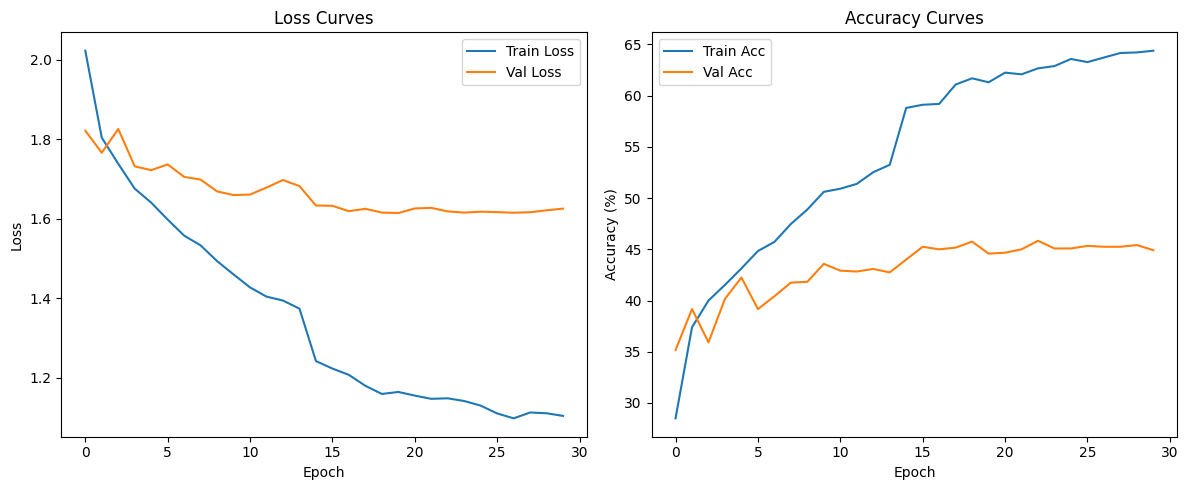

加载最佳模型并进行评估...


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 74.54it/s]

Test Loss: 1.6632, Test Acc: 43.83%
Accuracy of class 0: 35.00%
Accuracy of class 1: 65.83%
Accuracy of class 2: 36.67%
Accuracy of class 3: 68.33%
Accuracy of class 4: 27.50%
Accuracy of class 5: 24.17%
Accuracy of class 6: 31.67%
Accuracy of class 7: 53.33%
Accuracy of class 8: 47.50%
Accuracy of class 9: 48.33%
Test Loss: 1.6632
Test Accuracy: 43.83%


In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('.')
from layer2NN import main
results = main(
    img_size=84,           # 图像大小
    batch_size=32,         # 批量大小
    data_dir='data/custom-dataset',  # 数据集目录
    num_classes=10,        # 分类类别数
    show_plots=True        # 在notebook中显示图形
)
print(f"Test Loss: {results['test_loss']:.4f}")
print(f"Test Accuracy: {results['test_acc']:.2f}%")

使用设备: cuda
开始训练MLP模型...


Epoch 1/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.34it/s, loss=1.97, acc=29.2]
/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50: Train Loss: 2.2501, Train Acc: 18.36%, Val Loss: 1.9677, Val Acc: 29.25%
Model saved with Val Acc: 29.25%


Epoch 2/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.37it/s, loss=1.84, acc=33.7]


Epoch 2/50: Train Loss: 2.0081, Train Acc: 28.06%, Val Loss: 1.8371, Val Acc: 33.67%
Model saved with Val Acc: 33.67%


Epoch 3/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.93it/s, loss=1.77, acc=37.6]


Epoch 3/50: Train Loss: 1.8872, Train Acc: 32.50%, Val Loss: 1.7665, Val Acc: 37.58%
Model saved with Val Acc: 37.58%


Epoch 4/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.64it/s, loss=1.7, acc=40]   


Epoch 4/50: Train Loss: 1.8323, Train Acc: 35.94%, Val Loss: 1.7050, Val Acc: 40.00%
Model saved with Val Acc: 40.00%


Epoch 5/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.34it/s, loss=1.71, acc=40.5]


Epoch 5/50: Train Loss: 1.7904, Train Acc: 37.06%, Val Loss: 1.7058, Val Acc: 40.50%
Model saved with Val Acc: 40.50%


Epoch 6/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.05it/s, loss=1.66, acc=41.7]


Epoch 6/50: Train Loss: 1.7393, Train Acc: 39.25%, Val Loss: 1.6641, Val Acc: 41.67%
Model saved with Val Acc: 41.67%


Epoch 7/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.93it/s, loss=1.66, acc=41.5]


Epoch 7/50: Train Loss: 1.7220, Train Acc: 39.25%, Val Loss: 1.6627, Val Acc: 41.50%


Epoch 8/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.12it/s, loss=1.66, acc=40.8]


Epoch 8/50: Train Loss: 1.6890, Train Acc: 41.75%, Val Loss: 1.6557, Val Acc: 40.75%


Epoch 9/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.73it/s, loss=1.67, acc=43.2]


Epoch 9/50: Train Loss: 1.6582, Train Acc: 42.03%, Val Loss: 1.6679, Val Acc: 43.17%
Model saved with Val Acc: 43.17%


Epoch 10/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.72it/s, loss=1.63, acc=43.8]


Epoch 10/50: Train Loss: 1.6261, Train Acc: 43.89%, Val Loss: 1.6290, Val Acc: 43.83%
Model saved with Val Acc: 43.83%


Epoch 11/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.23it/s, loss=1.63, acc=43.8]


Epoch 11/50: Train Loss: 1.5972, Train Acc: 44.11%, Val Loss: 1.6331, Val Acc: 43.83%


Epoch 12/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.73it/s, loss=1.62, acc=43.1]


Epoch 12/50: Train Loss: 1.5762, Train Acc: 45.19%, Val Loss: 1.6220, Val Acc: 43.08%


Epoch 13/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.86it/s, loss=1.63, acc=43.3]


Epoch 13/50: Train Loss: 1.5620, Train Acc: 45.06%, Val Loss: 1.6264, Val Acc: 43.33%


Epoch 14/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 67.89it/s, loss=1.63, acc=43.3]


Epoch 14/50: Train Loss: 1.5551, Train Acc: 45.33%, Val Loss: 1.6334, Val Acc: 43.33%


Epoch 15/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.31it/s, loss=1.6, acc=44.2] 


Epoch 15/50: Train Loss: 1.5167, Train Acc: 48.50%, Val Loss: 1.6029, Val Acc: 44.25%
Model saved with Val Acc: 44.25%


Epoch 16/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.49it/s, loss=1.61, acc=45.2]


Epoch 16/50: Train Loss: 1.4992, Train Acc: 48.75%, Val Loss: 1.6100, Val Acc: 45.17%
Model saved with Val Acc: 45.17%


Epoch 17/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.52it/s, loss=1.62, acc=43.6]


Epoch 17/50: Train Loss: 1.4922, Train Acc: 48.42%, Val Loss: 1.6174, Val Acc: 43.58%


Epoch 18/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.05it/s, loss=1.59, acc=45.1]


Epoch 18/50: Train Loss: 1.4958, Train Acc: 48.25%, Val Loss: 1.5901, Val Acc: 45.08%


Epoch 19/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.10it/s, loss=1.62, acc=44.3]


Epoch 19/50: Train Loss: 1.4453, Train Acc: 50.28%, Val Loss: 1.6200, Val Acc: 44.33%


Epoch 20/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 78.97it/s, loss=1.6, acc=44.4] 


Epoch 20/50: Train Loss: 1.4301, Train Acc: 51.39%, Val Loss: 1.6044, Val Acc: 44.42%


Epoch 21/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.53it/s, loss=1.63, acc=44]  


Epoch 21/50: Train Loss: 1.4088, Train Acc: 52.03%, Val Loss: 1.6285, Val Acc: 44.00%


Epoch 22/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.33it/s, loss=1.6, acc=45.7] 


Epoch 22/50: Train Loss: 1.4011, Train Acc: 51.22%, Val Loss: 1.5994, Val Acc: 45.67%
Model saved with Val Acc: 45.67%


Epoch 23/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.96it/s, loss=1.62, acc=44.4]


Epoch 23/50: Train Loss: 1.3643, Train Acc: 53.56%, Val Loss: 1.6248, Val Acc: 44.42%


Epoch 24/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.13it/s, loss=1.59, acc=46.2]


Epoch 24/50: Train Loss: 1.3712, Train Acc: 53.08%, Val Loss: 1.5891, Val Acc: 46.17%
Model saved with Val Acc: 46.17%


Epoch 25/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.47it/s, loss=1.58, acc=46.2]


Epoch 25/50: Train Loss: 1.3447, Train Acc: 54.03%, Val Loss: 1.5795, Val Acc: 46.17%


Epoch 26/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.49it/s, loss=1.6, acc=46.4] 


Epoch 26/50: Train Loss: 1.3142, Train Acc: 54.94%, Val Loss: 1.5994, Val Acc: 46.42%
Model saved with Val Acc: 46.42%


Epoch 27/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.58it/s, loss=1.62, acc=45.9]


Epoch 27/50: Train Loss: 1.2971, Train Acc: 55.83%, Val Loss: 1.6154, Val Acc: 45.92%


Epoch 28/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.16it/s, loss=1.63, acc=45.3]


Epoch 28/50: Train Loss: 1.2873, Train Acc: 55.11%, Val Loss: 1.6321, Val Acc: 45.33%


Epoch 29/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.14it/s, loss=1.64, acc=44.2]


Epoch 29/50: Train Loss: 1.2665, Train Acc: 56.69%, Val Loss: 1.6408, Val Acc: 44.25%


Epoch 30/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.32it/s, loss=1.65, acc=46]  


Epoch 30/50: Train Loss: 1.2595, Train Acc: 56.50%, Val Loss: 1.6525, Val Acc: 46.00%


Epoch 31/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.90it/s, loss=1.64, acc=44.8]


Epoch 31/50: Train Loss: 1.2486, Train Acc: 56.72%, Val Loss: 1.6435, Val Acc: 44.75%


Epoch 32/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.16it/s, loss=1.66, acc=44]  


Epoch 32/50: Train Loss: 1.2158, Train Acc: 58.86%, Val Loss: 1.6638, Val Acc: 44.00%


Epoch 33/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.88it/s, loss=1.67, acc=45.7]


Epoch 33/50: Train Loss: 1.2006, Train Acc: 58.50%, Val Loss: 1.6670, Val Acc: 45.67%


Epoch 34/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.81it/s, loss=1.64, acc=44.8]


Epoch 34/50: Train Loss: 1.1934, Train Acc: 59.28%, Val Loss: 1.6386, Val Acc: 44.83%


Epoch 35/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 77.25it/s, loss=1.66, acc=45.8]


Epoch 35/50: Train Loss: 1.1607, Train Acc: 60.50%, Val Loss: 1.6577, Val Acc: 45.75%


Epoch 36/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.63it/s, loss=1.67, acc=45.1]


Epoch 36/50: Train Loss: 1.1706, Train Acc: 60.72%, Val Loss: 1.6674, Val Acc: 45.08%


Epoch 37/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.91it/s, loss=1.66, acc=46]  


Epoch 37/50: Train Loss: 1.1543, Train Acc: 60.33%, Val Loss: 1.6564, Val Acc: 46.00%


Epoch 38/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 61.69it/s, loss=1.67, acc=46.2]


Epoch 38/50: Train Loss: 1.1457, Train Acc: 61.61%, Val Loss: 1.6736, Val Acc: 46.17%


Epoch 39/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.64it/s, loss=1.68, acc=45.2]


Epoch 39/50: Train Loss: 1.1238, Train Acc: 61.64%, Val Loss: 1.6819, Val Acc: 45.17%


Epoch 40/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.08it/s, loss=1.7, acc=45.8] 


Epoch 40/50: Train Loss: 1.0872, Train Acc: 62.89%, Val Loss: 1.7022, Val Acc: 45.75%


Epoch 41/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.93it/s, loss=1.67, acc=45.7]


Epoch 41/50: Train Loss: 1.0617, Train Acc: 63.53%, Val Loss: 1.6709, Val Acc: 45.67%


Epoch 42/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.84it/s, loss=1.69, acc=46.1]


Epoch 42/50: Train Loss: 1.0672, Train Acc: 63.44%, Val Loss: 1.6879, Val Acc: 46.08%


Epoch 43/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.59it/s, loss=1.72, acc=45.8]


Epoch 43/50: Train Loss: 1.0704, Train Acc: 64.08%, Val Loss: 1.7219, Val Acc: 45.83%


Epoch 44/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.16it/s, loss=1.71, acc=45.3]


Epoch 44/50: Train Loss: 1.0627, Train Acc: 63.08%, Val Loss: 1.7131, Val Acc: 45.33%


Epoch 45/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.36it/s, loss=1.7, acc=45.4] 


Epoch 45/50: Train Loss: 1.0409, Train Acc: 65.50%, Val Loss: 1.6991, Val Acc: 45.42%


Epoch 46/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 66.32it/s, loss=1.75, acc=45.3]


Epoch 46/50: Train Loss: 1.0378, Train Acc: 64.92%, Val Loss: 1.7480, Val Acc: 45.33%


Epoch 47/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 77.08it/s, loss=1.73, acc=46.4]


Epoch 47/50: Train Loss: 0.9932, Train Acc: 65.61%, Val Loss: 1.7303, Val Acc: 46.42%


Epoch 48/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.29it/s, loss=1.71, acc=47.4]


Epoch 48/50: Train Loss: 1.0023, Train Acc: 67.25%, Val Loss: 1.7103, Val Acc: 47.42%
Model saved with Val Acc: 47.42%


Epoch 49/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.57it/s, loss=1.77, acc=45.9]


Epoch 49/50: Train Loss: 0.9554, Train Acc: 67.56%, Val Loss: 1.7661, Val Acc: 45.92%


Epoch 50/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.10it/s, loss=1.77, acc=46.2]


Epoch 50/50: Train Loss: 0.9610, Train Acc: 68.03%, Val Loss: 1.7721, Val Acc: 46.17%


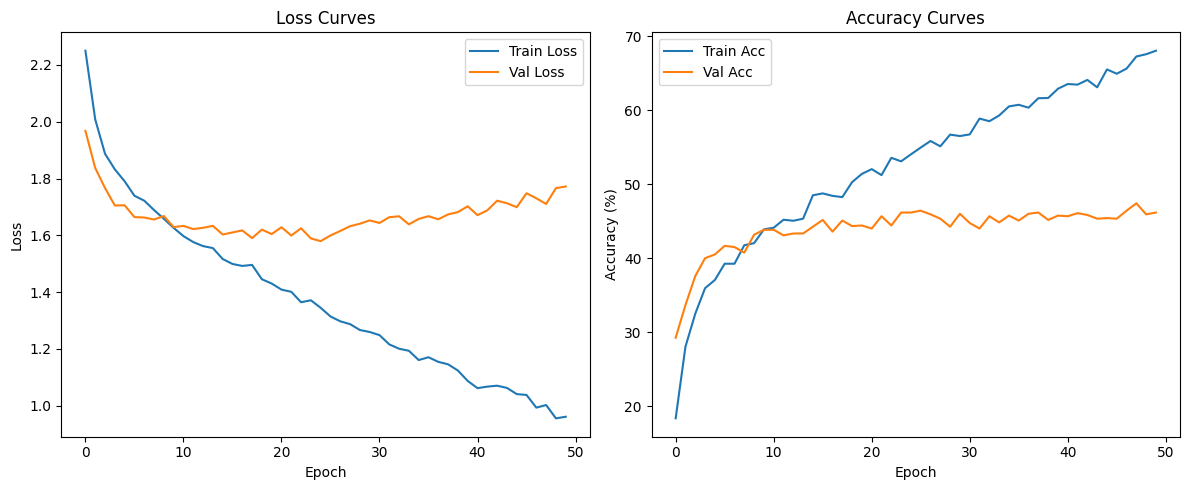

加载最佳模型并进行评估...


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 76.33it/s]

Test Loss: 1.8321, Test Acc: 43.75%
Accuracy of class 0: 39.17%
Accuracy of class 1: 69.17%
Accuracy of class 2: 45.00%
Accuracy of class 3: 56.67%
Accuracy of class 4: 29.17%
Accuracy of class 5: 28.33%
Accuracy of class 6: 28.33%
Accuracy of class 7: 55.00%
Accuracy of class 8: 42.50%
Accuracy of class 9: 44.17%
Test Loss: 1.8321
Test Accuracy: 43.75%


In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('.')
from mlp import main as mlp_main
import torch
import numpy as np
torch.manual_seed(42)
np.random.seed(42)
results = mlp_main(
    show_plots=True      
)
print(f"Test Loss: {results['test_loss']:.4f}")
print(f"Test Accuracy: {results['test_acc']:.2f}%")

使用设备: cuda
CNN模型结构已创建，输出类别=10
开始训练CNN模型...


Epoch 1/50 [Train]:   0%|          | 0/113 [00:00<?, ?it/s]/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.09it/s, loss=1.66, acc=43]  


Epoch 1/50: Train Loss: 1.8148, Train Acc: 37.22%, Val Loss: 1.6594, Val Acc: 43.00%
Model saved with Val Acc: 43.00%


Epoch 2/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.24it/s, loss=1.69, acc=43.7]


Epoch 2/50: Train Loss: 1.5818, Train Acc: 45.17%, Val Loss: 1.6874, Val Acc: 43.67%
Model saved with Val Acc: 43.67%


Epoch 3/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 67.66it/s, loss=1.45, acc=49]  


Epoch 3/50: Train Loss: 1.4598, Train Acc: 49.72%, Val Loss: 1.4519, Val Acc: 49.00%
Model saved with Val Acc: 49.00%


Epoch 4/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.06it/s, loss=1.36, acc=51.8]


Epoch 4/50: Train Loss: 1.4403, Train Acc: 51.25%, Val Loss: 1.3603, Val Acc: 51.83%
Model saved with Val Acc: 51.83%


Epoch 5/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.31it/s, loss=1.25, acc=57]   


Epoch 5/50: Train Loss: 1.3429, Train Acc: 53.53%, Val Loss: 1.2537, Val Acc: 57.00%
Model saved with Val Acc: 57.00%


Epoch 6/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.40it/s, loss=1.42, acc=53.7] 


Epoch 6/50: Train Loss: 1.2644, Train Acc: 56.56%, Val Loss: 1.4156, Val Acc: 53.67%


Epoch 7/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 68.06it/s, loss=1.32, acc=52.5]


Epoch 7/50: Train Loss: 1.2316, Train Acc: 57.94%, Val Loss: 1.3157, Val Acc: 52.50%


Epoch 8/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.32it/s, loss=1.61, acc=49.1]


Epoch 8/50: Train Loss: 1.1687, Train Acc: 60.56%, Val Loss: 1.6104, Val Acc: 49.08%


Epoch 9/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.28it/s, loss=1.2, acc=61.1]  


Epoch 9/50: Train Loss: 1.1573, Train Acc: 60.42%, Val Loss: 1.2042, Val Acc: 61.08%
Model saved with Val Acc: 61.08%


Epoch 10/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.46it/s, loss=1.23, acc=57.4]


Epoch 10/50: Train Loss: 1.1234, Train Acc: 61.56%, Val Loss: 1.2343, Val Acc: 57.42%


Epoch 11/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 68.76it/s, loss=1.17, acc=60.2] 


Epoch 11/50: Train Loss: 1.1139, Train Acc: 61.42%, Val Loss: 1.1681, Val Acc: 60.17%


Epoch 12/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.74it/s, loss=1.32, acc=54.1]


Epoch 12/50: Train Loss: 1.0543, Train Acc: 63.81%, Val Loss: 1.3162, Val Acc: 54.08%


Epoch 13/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.61it/s, loss=1.08, acc=64.2] 


Epoch 13/50: Train Loss: 1.0535, Train Acc: 64.11%, Val Loss: 1.0778, Val Acc: 64.25%
Model saved with Val Acc: 64.25%


Epoch 14/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.68it/s, loss=1.04, acc=64.9] 


Epoch 14/50: Train Loss: 1.0166, Train Acc: 65.86%, Val Loss: 1.0442, Val Acc: 64.92%
Model saved with Val Acc: 64.92%


Epoch 15/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.99it/s, loss=1.13, acc=60.9]


Epoch 15/50: Train Loss: 1.0158, Train Acc: 65.11%, Val Loss: 1.1284, Val Acc: 60.92%


Epoch 16/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.48it/s, loss=1.39, acc=52.5]


Epoch 16/50: Train Loss: 0.9933, Train Acc: 66.44%, Val Loss: 1.3945, Val Acc: 52.50%


Epoch 17/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 73.41it/s, loss=0.948, acc=66.2]


Epoch 17/50: Train Loss: 0.9758, Train Acc: 66.97%, Val Loss: 0.9479, Val Acc: 66.25%
Model saved with Val Acc: 66.25%


Epoch 18/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.92it/s, loss=1.24, acc=60.6]


Epoch 18/50: Train Loss: 0.9377, Train Acc: 67.08%, Val Loss: 1.2370, Val Acc: 60.58%


Epoch 19/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.31it/s, loss=1.01, acc=65.5] 


Epoch 19/50: Train Loss: 0.9312, Train Acc: 68.22%, Val Loss: 1.0083, Val Acc: 65.50%


Epoch 20/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.82it/s, loss=0.942, acc=67.2]


Epoch 20/50: Train Loss: 0.9124, Train Acc: 68.14%, Val Loss: 0.9424, Val Acc: 67.17%
Model saved with Val Acc: 67.17%


Epoch 21/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 68.97it/s, loss=1.66, acc=47.3]


Epoch 21/50: Train Loss: 0.8948, Train Acc: 69.64%, Val Loss: 1.6591, Val Acc: 47.33%


Epoch 22/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.08it/s, loss=0.989, acc=66.6]


Epoch 22/50: Train Loss: 0.8570, Train Acc: 70.64%, Val Loss: 0.9893, Val Acc: 66.58%


Epoch 23/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 68.41it/s, loss=1.42, acc=53.4]


Epoch 23/50: Train Loss: 0.8494, Train Acc: 70.78%, Val Loss: 1.4199, Val Acc: 53.42%


Epoch 24/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.93it/s, loss=1.05, acc=66.3] 


Epoch 24/50: Train Loss: 0.8379, Train Acc: 70.97%, Val Loss: 1.0532, Val Acc: 66.33%


Epoch 25/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 66.43it/s, loss=0.707, acc=75.9]


Epoch 25/50: Train Loss: 0.6464, Train Acc: 79.03%, Val Loss: 0.7069, Val Acc: 75.92%
Model saved with Val Acc: 75.92%


Epoch 26/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.89it/s, loss=0.673, acc=77.2]


Epoch 26/50: Train Loss: 0.5499, Train Acc: 81.56%, Val Loss: 0.6732, Val Acc: 77.17%
Model saved with Val Acc: 77.17%


Epoch 27/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 76.54it/s, loss=0.676, acc=77.4]


Epoch 27/50: Train Loss: 0.5204, Train Acc: 83.11%, Val Loss: 0.6756, Val Acc: 77.42%
Model saved with Val Acc: 77.42%


Epoch 28/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.07it/s, loss=0.674, acc=76.3]


Epoch 28/50: Train Loss: 0.4856, Train Acc: 84.58%, Val Loss: 0.6736, Val Acc: 76.33%


Epoch 29/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.84it/s, loss=0.658, acc=79.2]


Epoch 29/50: Train Loss: 0.4521, Train Acc: 85.72%, Val Loss: 0.6584, Val Acc: 79.17%
Model saved with Val Acc: 79.17%


Epoch 30/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.58it/s, loss=0.663, acc=78.8]


Epoch 30/50: Train Loss: 0.4388, Train Acc: 86.25%, Val Loss: 0.6631, Val Acc: 78.83%


Epoch 31/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.90it/s, loss=0.658, acc=77.9]


Epoch 31/50: Train Loss: 0.4015, Train Acc: 87.28%, Val Loss: 0.6584, Val Acc: 77.92%


Epoch 32/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.01it/s, loss=0.661, acc=77.6]


Epoch 32/50: Train Loss: 0.3975, Train Acc: 87.53%, Val Loss: 0.6615, Val Acc: 77.58%


Epoch 33/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 72.86it/s, loss=0.654, acc=78.9]


Epoch 33/50: Train Loss: 0.3776, Train Acc: 88.36%, Val Loss: 0.6545, Val Acc: 78.92%


Epoch 34/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.50it/s, loss=0.669, acc=78.2]


Epoch 34/50: Train Loss: 0.3502, Train Acc: 90.17%, Val Loss: 0.6685, Val Acc: 78.17%


Epoch 35/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.57it/s, loss=0.664, acc=77.7]


Epoch 35/50: Train Loss: 0.3470, Train Acc: 89.36%, Val Loss: 0.6639, Val Acc: 77.67%


Epoch 36/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.53it/s, loss=0.657, acc=79.3]


Epoch 36/50: Train Loss: 0.3462, Train Acc: 88.94%, Val Loss: 0.6569, Val Acc: 79.33%
Model saved with Val Acc: 79.33%


Epoch 37/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 68.10it/s, loss=0.673, acc=78.2]


Epoch 37/50: Train Loss: 0.3100, Train Acc: 90.36%, Val Loss: 0.6726, Val Acc: 78.25%


Epoch 38/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 63.92it/s, loss=0.651, acc=79.1]


Epoch 38/50: Train Loss: 0.2801, Train Acc: 91.61%, Val Loss: 0.6507, Val Acc: 79.08%


Epoch 39/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.83it/s, loss=0.659, acc=78.5]


Epoch 39/50: Train Loss: 0.2688, Train Acc: 92.53%, Val Loss: 0.6587, Val Acc: 78.50%


Epoch 40/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.96it/s, loss=0.653, acc=79.3]


Epoch 40/50: Train Loss: 0.2642, Train Acc: 92.61%, Val Loss: 0.6531, Val Acc: 79.33%


Epoch 41/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.64it/s, loss=0.651, acc=78.9]


Epoch 41/50: Train Loss: 0.2720, Train Acc: 91.81%, Val Loss: 0.6513, Val Acc: 78.92%


Epoch 42/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.06it/s, loss=0.642, acc=78.8]


Epoch 42/50: Train Loss: 0.2706, Train Acc: 92.06%, Val Loss: 0.6418, Val Acc: 78.75%


Epoch 43/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 70.61it/s, loss=0.655, acc=78.9]


Epoch 43/50: Train Loss: 0.2456, Train Acc: 93.42%, Val Loss: 0.6552, Val Acc: 78.92%


Epoch 44/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.96it/s, loss=0.653, acc=79.1]


Epoch 44/50: Train Loss: 0.2530, Train Acc: 92.86%, Val Loss: 0.6533, Val Acc: 79.08%


Epoch 45/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 71.68it/s, loss=0.653, acc=78.9]


Epoch 45/50: Train Loss: 0.2505, Train Acc: 92.94%, Val Loss: 0.6533, Val Acc: 78.92%


Epoch 46/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.22it/s, loss=0.653, acc=79.3]


Epoch 46/50: Train Loss: 0.2417, Train Acc: 93.58%, Val Loss: 0.6526, Val Acc: 79.33%


Epoch 47/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 60.24it/s, loss=0.649, acc=78.8]


Epoch 47/50: Train Loss: 0.2441, Train Acc: 93.58%, Val Loss: 0.6486, Val Acc: 78.83%


Epoch 48/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 69.70it/s, loss=0.653, acc=78.8]


Epoch 48/50: Train Loss: 0.2396, Train Acc: 93.25%, Val Loss: 0.6526, Val Acc: 78.83%


Epoch 49/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 74.35it/s, loss=0.655, acc=79.4]


Epoch 49/50: Train Loss: 0.2431, Train Acc: 93.61%, Val Loss: 0.6551, Val Acc: 79.42%
Model saved with Val Acc: 79.42%


Epoch 50/50 [Val]: 100%|██████████| 38/38 [00:00<00:00, 75.28it/s, loss=0.654, acc=78.8]


Epoch 50/50: Train Loss: 0.2373, Train Acc: 93.22%, Val Loss: 0.6541, Val Acc: 78.83%


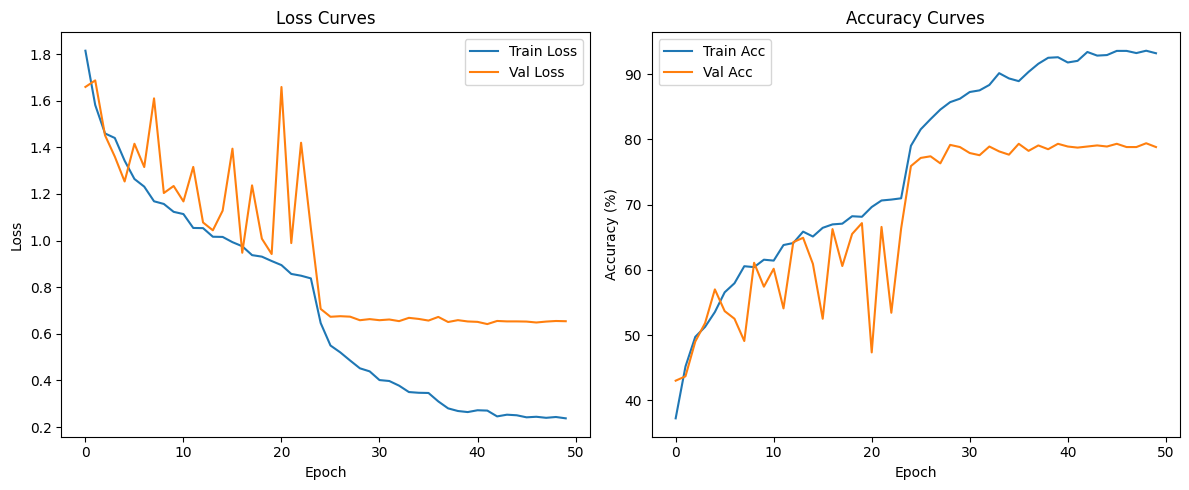

加载最佳模型并进行评估...


Evaluating: 100%|██████████| 38/38 [00:00<00:00, 72.93it/s]


Test Loss: 0.6673, Test Acc: 77.50%
Accuracy of class 0: 85.00%
Accuracy of class 1: 89.17%
Accuracy of class 2: 85.00%
Accuracy of class 3: 86.67%
Accuracy of class 4: 54.17%
Accuracy of class 5: 75.83%
Accuracy of class 6: 64.17%
Accuracy of class 7: 78.33%
Accuracy of class 8: 77.50%
Accuracy of class 9: 79.17%


ValueError: Unknown format code 'f' for object of type 'str'

In [2]:
from cnn import *
import matplotlib.pyplot as plt
%matplotlib inline
history, test_loss, test_acc, fig = main(img_size=84, show_plots=True)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accurarcy: {test_acc:.2f}%")